## Introduction to tensors

In the previous section, we used NumPy to manipulate arrays of float and SciPy for optimisation methods after we gave a shot at implementing basic gradient descent methods. NumPy provides an API for multi-dimensional matrices:

In [1]:
%load_ext lab_black

In [2]:
import numpy as np

- a zero-dimension array would be called a **scalar**;
  ```python
  >>> np.zeros(())  # the empty tuple
  array(0.)
  ```
- one-dimension would be a **vector**;
  ```python
  >>> np.zeros((5,))  # or np.zeros(5)
  array([0., 0., 0., 0., 0.])
  ```
- two-dimension a **matrix**;
  ```python
  >>> np.zeros(5, 5)
  array([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]])
   ```
   
In the general case, we call such a structure a **tensor**.


![](../images/linear_dogs.jpg)

Image credit: http://karlstratos.com/#drawings

![](../images/thatsallfolks.jpg)

Well, yes, that's all, of course. But there's more.

While it is true that we could train neural networks with NumPy arrays (it is really not complicated – but out of topic here), the point of libraries like PyTorch is to bring more than what NumPy already provides.

But to start with, PyTorch provides all what NumPy does. So a NumPy array is (like) a PyTorch tensor.

In [1]:
import torch

torch.zeros(())

tensor(0.)

In [4]:
torch.zeros(5)

tensor([0., 0., 0., 0., 0.])

In [5]:
torch.zeros(5, 5)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## Automatic differentiation with `autograd`

There are basically two additional functionalities provided by tensors:

1. you can send them to GPU for faster parallel computations (but avoid Python functions and loops like the plague and focus on torch implementations to really benefit from them);

In [ ]:
torch.ones(1, device=0)  # we use "cpu" if we don't want to make things complicated

tensor([1.], device='cuda:0')

2. (the most precious) computations propagate their gradient values!

In [ ]:
x0 = torch.ones(1, requires_grad=True)
y0 = x0 ** 2
y0.backward()
x0.grad

tensor([2.])

<div class="alert alert-warning"><b>Exercice:</b><br/>
    Can you confirm you really expected the value 2 here?
</div>

<details><summary><b>Solution</b> (click to unfold)</summary>
    The derivative of the function $x \mapsto x^2$ is $x \mapsto 2\,x$ which evaluates to 2 for $x=1$.
</details>

So let's now come back to the initialisation of our city placement problem:

In [2]:
import numpy as np

cities = [
    'Amsterdam', 'Athens', 'Barcelone', 'Belgrade', 'Berlin', 'Brussels',
    'Bucarest', 'Budapest', 'Copenhagen', 'Dublin', 'Gibraltar', 'Helsinki',
    'Istanbul', 'Kiev', 'Kiruna', 'Lisbon', 'London', 'Madrid',
    'Milan', 'Moscow', 'Munich', 'Oslo', 'Paris', 'Prague',
    'Reykjavik', 'Riga', 'Rome', 'Sofia', 'Stockholm', 'Tallinn',
    'Toulouse', 'Trondheim', 'Varsovie', 'Vienne', 'Vilnius', 'Zurich'
]
n = len(cities)

distances = np.load("distances.npy")
print(distances.shape)

(36, 36)


In [3]:
# initial random position
x0 = np.random.normal(size=(n, 2))

# normalize distance matrix
l1, l2 = np.meshgrid(x0[:, 0], x0[:, 0])
r1, r2 = np.meshgrid(x0[:, 1], x0[:, 1])
x0 /= np.linalg.norm(np.sqrt((l1 - l2) ** 2 + (r1 - r2) ** 2))
distances /= np.linalg.norm(distances)

Things will not change much with PyTorch: but we will not fail to specify that we don't want to compute the gradient, because it was really tedious.

Let's attach the distance matrix to the GPU for our computation, but apart from that, the API is really similar:

In [4]:
distances = torch.Tensor(distances).to(0)
distances /= torch.linalg.norm(distances)

Let's put this all in a function as we are going to reinitialise it several times in the following:

In [5]:
def init_t0():
    t0 = torch.randn((n, 2), dtype=float, requires_grad=True, device=0)

    with torch.no_grad():
        l1, l2 = torch.meshgrid(t0[:, 0], t0[:, 0])
        r1, r2 = torch.meshgrid(t0[:, 1], t0[:, 1])
        t0 /= torch.linalg.norm(torch.sqrt((l1 - l2) ** 2 + (r1 - r2) ** 2))

    return t0


t0 = init_t0()

/opt/miniconda3/envs/torch39/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635068699003/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


This implementation we had is a bit awkward for torch, so let's benefit from the `cdist` function which computes exactly the same code, without the (buzzkill) loop:

In [6]:
def criterion(*args):
    """Compute the map reconstruction objective function.

    Vector reshaped for more readability.
    """
    res = 0
    x = np.array(args).reshape((n, 2))  # tuple -> np.array (2D)
    for i in range(n):
        for j in range(i + 1, n):
            (x1, y1), (x2, y2) = x[i, :], x[j, :]
            delta = (x2 - x1) ** 2 + (y2 - y1) ** 2 - distances[i, j] ** 2
            res += delta ** 2
    return res

In [7]:
def criterion(x: torch.Tensor):
    return ((torch.cdist(x, x) ** 2 - distances ** 2) ** 2).sum() / 2


loss = criterion(t0)
loss

tensor(0.0007, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

We named the variable loss here, because that is the metric we usually want to minimise in a neural network. Here, we basically implemented a distance based loss. And the great thing, is that we got the gradient for free!

In [15]:
loss.backward()
t0.grad

tensor([[ 1.6303e-03,  1.2010e-04],
        [ 2.7972e-05, -4.3371e-05],
        [-1.7870e-04,  3.1000e-04],
        [-7.6353e-05, -1.7342e-04],
        [ 5.9719e-03,  7.0239e-03],
        [-5.5789e-03, -2.2672e-05],
        [ 9.5924e-05,  7.2832e-06],
        [ 2.7809e-04,  2.1084e-04],
        [ 1.3697e-03,  1.5597e-04],
        [ 7.5150e-05, -2.2429e-05],
        [-1.4942e-03,  3.5946e-04],
        [ 2.2327e-04, -5.7738e-04],
        [-6.7665e-05, -6.5540e-06],
        [ 2.3709e-04, -2.5431e-04],
        [ 6.4434e-04, -1.2630e-03],
        [-1.4394e-03,  1.1458e-03],
        [-2.1801e-03, -6.0656e-03],
        [-5.7613e-04,  4.5141e-05],
        [-4.4262e-05,  3.8986e-04],
        [ 3.1253e-04, -2.4427e-04],
        [ 2.5355e-03, -3.9014e-03],
        [-4.6826e-04,  8.6865e-05],
        [ 1.8919e-03, -6.5494e-04],
        [ 2.1489e-03,  6.3763e-05],
        [ 2.0217e-03, -1.5712e-03],
        [-3.9811e-03, -1.0250e-03],
        [-1.0477e-03, -3.4840e-04],
        [ 6.5513e-05,  8.553

So let's give it a first shot with a naive constant step (we call it a *learning rate*) gradient descent:

In [9]:
from tqdm import tqdm

n_epochs = 4000
learning_rate = 1e-1

loss_values = list()
t0 = init_t0()

for i in tqdm(range(n_epochs)):

    loss = criterion(t0)
    loss.backward()

    # bring the loss back to Earth
    loss_values.append(loss.cpu().detach().numpy().item())

    # we need this guard because we want to update t0 based on its gradient
    # which would change its gradient, so let's stop keeping track of gradient
    with torch.no_grad():
        t0 -= learning_rate * t0.grad
        t0.grad.zero_()

100%|█████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 725.82it/s]


We can check the convergence of the algorithm (it is common practice to have it in semi-log).


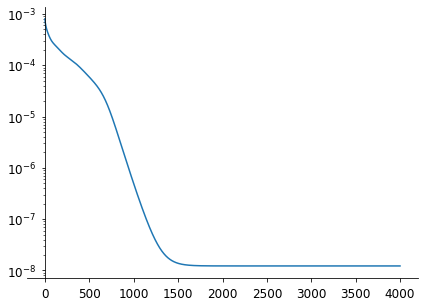

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
ax.semilogy(loss_values)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.tick_params(pad=5, labelsize=12)

It is quite slow actually... so much for GPU!  
Remember we converged within 34 iterations with SciPy BFGS, but we have things in place, and we can confirm city placement is correct:

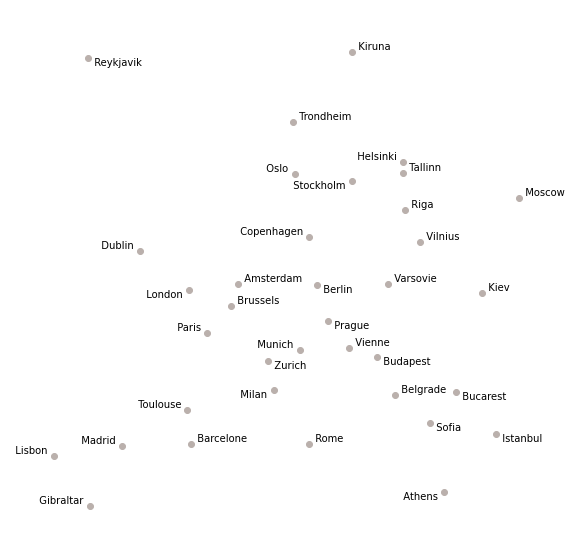

In [129]:
from collections import defaultdict

def plot_cities(ax, t0, history = None):

    res = t0.cpu().detach().numpy()

    # rotate it so that Copenhagen is North of Rome
    south, north = cities.index("Rome"), cities.index("Copenhagen")
    d = res[north, :] - res[south, :]
    rotate = np.arctan2(d[1], d[0]) - np.pi / 2
    mat_rotate = np.array(
        [[np.cos(rotate), -np.sin(rotate)], [np.sin(rotate), np.cos(rotate)]]
    )
    res = res @ mat_rotate

    # mirror so that Reykjavik is west of Moscow
    west, east = cities.index("Reykjavik"), cities.index("Moscow")
    mirror = False
    if res[west, 0] > res[east, 0]:
        mirror = True
        res[:, 0] *= -1
        
    if history is not None:
        history = list(h@mat_rotate for h in history)
        if mirror:
            history = list(h * torch.Tensor([-1, 1]) for h in history)


    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()

    # Trimming the final image

    bx = min(res[:, 0]), max(res[:, 0])
    dx = bx[1] - bx[0]
    ax.set_xlim(bx[0] - 0.1 * dx, bx[1] + 0.1 * dx)

    by = min(res[:, 1]), max(res[:, 1])
    dy = by[1] - by[0]
    ax.set_ylim(by[0] - 0.1 * dy, by[1] + 0.1 * dy)

    # label placement: subject to automatic optimization!

    d = defaultdict(lambda: {"ha": "left", "va": "bottom"})

    for city in [
        "Barcelona",
        "Berlin",
        "Bucarest",
        "Budapest",
        "Istanbul",
        "Prague",
        "Reykjavik",
        "Sofia",
        "Zurich",
    ]:
        d[city] = {"ha": "left", "va": "top"}
    for city in [
        "Athens",
        "London",
        "Milan",
        "Stockholm",
    ]:
        d[city] = {"ha": "right", "va": "top"}
    for city in [
        "Copenhagen",
        "Dublin",
        "Edinburgh",
        "Gibraltar",
        "Helsinki",
        "Lisbon",
        "Madrid",
        "Munich",
        "Nantes",
        "Oslo",
        "Paris",
        "Toulouse",
    ]:
        d[city] = {"ha": "right", "va": "bottom"}


    for ((x, y), city) in zip(res, cities):
        ax.scatter(x, y, color="#bab0ac")
        ax.annotate("  " + city + "  ", (x, y), **d[city])
        
    return history

fig, ax = plt.subplots(figsize=(10, 10))
plot_cities(ax, t0)

## Optimisers in PyTorch

Many optimisation engines are implemented in PyTorch: these are not necessarily the most appropriate for a wide range of problems, but these methods usually work well for the optimisation of neural networks.

- The most famous method is the *Stochastic Gradient Descent* (SGD): instead of evaluating the gradient on all samples of our training dataset, we estimate the gradient based on a subset of samples. This method sounds very naive but it happens to work well with neural networks.

  In our city problem, we have few samples, so we pass them all at each epoch, and our SGD is just a fixed step gradient descent.

In [150]:
from torch import optim


n_epochs = 4000
loss_values = list()
history = list()

t0 = init_t0()
optimizer = optim.SGD([t0], lr=1e-1)


for i in tqdm(range(n_epochs)):

    loss = criterion(t0)
    loss.backward()
    loss_values.append(loss.cpu().detach().numpy().item())
    history.append(t0.cpu().detach())

    optimizer.step()
    optimizer.zero_grad()

100%|█████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 753.11it/s]


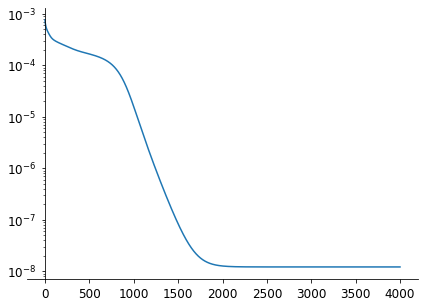

In [151]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.semilogy(loss_values)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.tick_params(pad=5, labelsize=12)

  The convergence is rather slow according to the loss, because of the fixed learning rate, and we can see from the trajectory of few cities how the convergence is going (there is one point per epoch).

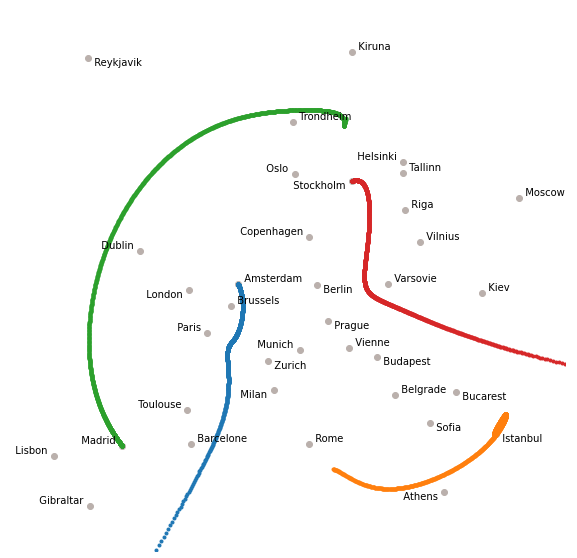

In [152]:
fig, ax = plt.subplots(figsize=(10, 10))
h = plot_cities(ax, t0, history)

ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 0, :].T, '.')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 12, :].T, '.')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 17, :].T, '.')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 28, :].T, '.')

- **ADAM** stands for *Adaptive Moment Estimation* and is a good default optimiser for neural networks. It works well with large problems consisting of many parameters and requiring a lot of data in input.
  The method controls the learning rate during the optimisation so that there is minimum oscillation when it reaches the global minimum while taking big enough steps along the way.

In [153]:
from torch import optim

n_epochs = 400
loss_values = list()
history = list()

t0 = init_t0()
optimizer = optim.Adam([t0], lr=1e-1)


for i in tqdm(range(n_epochs)):

    loss = criterion(t0)
    loss.backward()
    loss_values.append(loss.cpu().detach().numpy().item())
    history.append(t0.cpu().detach())

    optimizer.step()
    optimizer.zero_grad()

100%|███████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 359.78it/s]


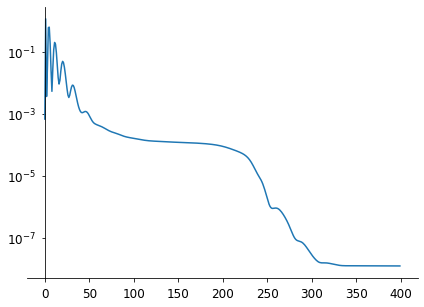

In [154]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.semilogy(loss_values)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.tick_params(pad=5, labelsize=12)

The convergence is very chaotic in the first iterations (with a loss oscillation!) but it converges very fast after that.

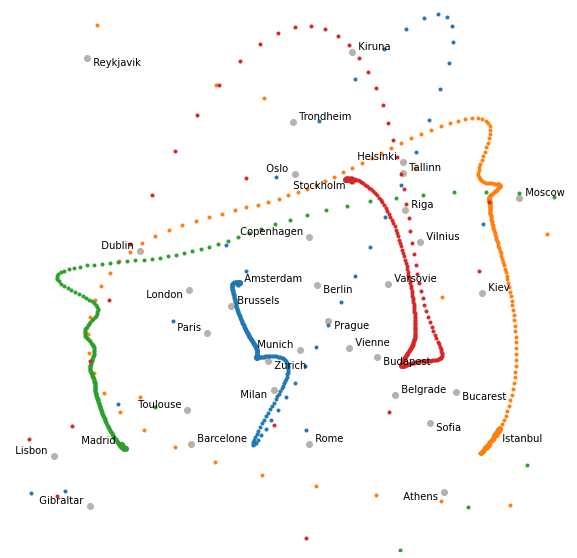

In [155]:
fig, ax = plt.subplots(figsize=(10, 10))
h = plot_cities(ax, t0, history)

ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 0, :].T, '.')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 12, :].T, '.')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 17, :].T, '.')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 28, :].T, '.')

- **BFGS** was the method leading to the fastest convergence. It is also available in PyTorch as a variant (**L-BFGS**) which is an approximation to BFGS which requires less memory.

In [178]:
from torch import optim

n_epochs = 10
loss_values = list()
history= list()

t0 = init_t0()
optimizer = optim.LBFGS([t0])


def closure():
    optimizer.zero_grad()
    loss = criterion(t0)
    
    loss_values.append(loss.cpu().detach().numpy().item())
    history.append(t0.cpu().detach())
    
    loss.backward()
    return loss


for i in tqdm(range(n_epochs)):
    loss = optimizer.step(closure)
    loss_values.append(None)
    optimizer.zero_grad()

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.39it/s]


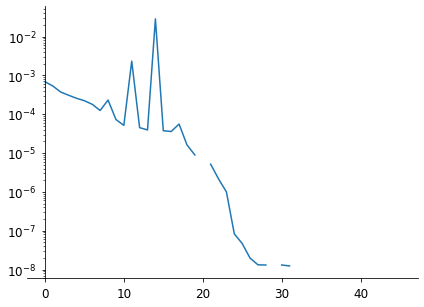

In [179]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.semilogy(loss_values)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.tick_params(pad=5, labelsize=12)

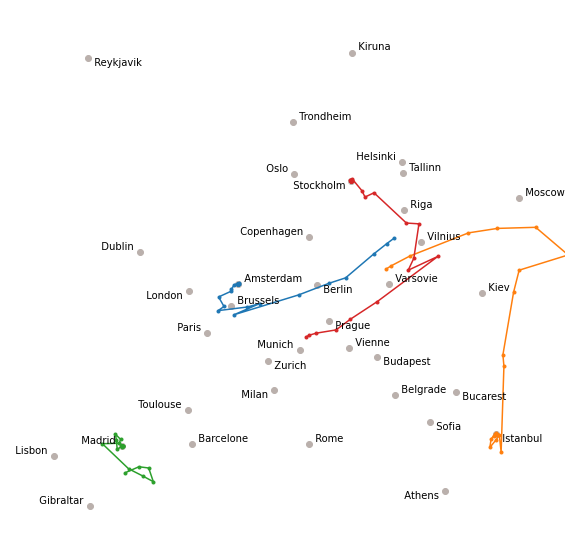

In [170]:
fig, ax = plt.subplots(figsize=(10, 10))
h = plot_cities(ax, t0, history)

ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 0, :].T, '.-')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 12, :].T, '.-')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 17, :].T, '.-')
ax.plot(*torch.concat(h).reshape(-1, n, 2)[:, 28, :].T, '.-')

## Exercice: Linear regression

Regression is a more traditional ML problem. We can show here how to address a simple version of the problem (which also has an analytical solution) with an optimisation method like ADAM.

1. Start by generating sample points around a straight line, as below

In [180]:
x = 2 * torch.rand(100, 1, device=0)
y = 3 * x + 4 + torch.randn(100, 1, device=0)

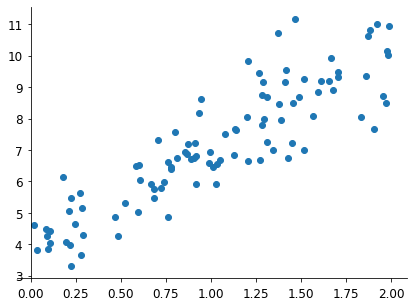

In [181]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x.cpu(), y.cpu())

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.tick_params(pad=5, labelsize=12)

2. Implement the metric (loss) you need to optimise;
3. Try different initial learning rate values and observe the convergence behaviour;
4. Look at the convergence process in the animations below: can you explain what happened with the learning rate values?